In [472]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split as scikit_train_test_split
from surprise import Reader, Dataset, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, CoClustering, SlopeOne, SVDpp, NMF, BaselineOnly
from surprise.model_selection import KFold, GridSearchCV
from surprise.model_selection import train_test_split as surprise_train_test_split
import time

Data import:

In [473]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")

Data cleaning - Drop all skills which occur less than x times in dataset: <br> <br>
***for insights in why skills of this frequency are dropped please refer to Appendix I***

In [474]:
def get_rare_skills(data,n):
    skill_frequency = {}
    for skill in data["skill"].unique():
        skill_frequency[skill] = data[data["skill"] == skill]["person"].nunique()

    return [s for s,f in skill_frequency.items() if f <= n]

In [475]:
# rare_skills = get_rare_skills(df,5)
# df = df[~df["skill"].isin(rare_skills)]

Declare various aiding variables

In [476]:
persons = df["person"].unique()
skills = sorted(df["skill"].unique())
categories = df["category"].unique()

In [477]:
employee_dict = {}
for n in range(1,len(persons)+1):
    employee_dict[n] = persons[n-1]

In [478]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Since this notebook demonstrates the a recommender system which deals with rated skills and the underlying data does not offer ratings, this measure will be implemented in the following way: 
- For each skill, the frequency of the underlying category will be measured. The skills will be rated according to this frequency 
- For example: If an employee has most skills in the category "Programmiersprachen", these skills will receive the highest rating

In [479]:
def scaler_1_5(x,old_max,old_min):
    old_range = (old_max - old_min)  
    if (old_range == 0):
        return 1
    else:
        new_range = (5 - 1) 
        x_std = (x - old_min)/(old_max-old_min)
        return round(x_std * new_range + 1)

In [480]:
def get_rated_df(data):
    # create dataframe for each employee and their category count
    category_per_employee = pd.DataFrame(index=data["category"].unique())
    for p in data["person"].unique():
        p_skills = data[data["person"] == p]
        # count categories for each employee
        category_count = p_skills["category"].value_counts()
        category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
        skill_values = np.array([])
        # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
        for cat in categories:
            try:
                skill_values = np.append(skill_values,category_count[cat])
            except KeyError:
                skill_values = np.append(skill_values,0)
        # add employee data to dataframe
        p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
        category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

    df_rated = pd.DataFrame()
    for p in data["person"].unique():
        # get employee
        df_subset = data[data["person"] == p].copy()
        # get skills of employee
        p_skills = df_subset["skill"].to_numpy()
        # initialize empty array for ratings
        ratings = np.zeros(len(p_skills))
        # fill array for each skill with respective category value 
        for i in range(0,len(p_skills)): 
            ratings[i] = category_per_employee.loc[category_dict[p_skills[i]]][p]
        # append ratings to subset and drop category column
        df_subset["rating"] = ratings
        df_subset.drop("category",axis=1,inplace=True)
        # append user to df
        df_rated = pd.concat([df_rated,df_subset],ignore_index=True)

    return df_rated

In [481]:
df_rated = get_rated_df(df)

Normalization of data: <br>
Since this notebook is dealing with rated skills and the used models should deal with the true ratings of the skills, no further transformation of the data is applied.

## Comparing Different Recommender Systems

Define holdout data: Remove 10% of high rated datapoints from dataset

In [482]:
def get_holdout(data,size):
    # save original size of data for termination of while loop 
    size_data = len(data)
    holdout = pd.DataFrame()
    # get list which represents each employee with their number of entered skills in the data
    employee_occurence = data["person"].to_list()
    rare_skills = get_rare_skills(df_rated,5)
    # initialize random seed
    seed = 0 
    while len(holdout)/size_data < size:
        # randomly select employee (affected by how often they occur in the data)
        np.random.seed(seed)
        df_subset_emp = data[(data["person"] == np.random.choice(employee_occurence))]
        # prune rare skills from dataset so skills do not get randomly eliminated from training data
        df_subset_pruned = df_subset_emp[~df_subset_emp["skill"].isin(rare_skills)]
        # if condition causes that employee do not get completely deleted from dataset
        if len(df_subset_pruned) > 1:
            max_rating_emp = df_subset_pruned["rating"].max()
            holdout_emp = df_subset_pruned[df_subset_pruned["rating"] == max_rating_emp].sample(n=1,random_state=seed)
            data.drop(holdout_emp.index,inplace=True)
            holdout = pd.concat([holdout,holdout_emp],ignore_index=True)
        # change seed for next while iteration
        seed = seed + 1
    return holdout

In [483]:
holdout = get_holdout(df_rated,0.1)

In [484]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df_rated,reader)

In [485]:
NUM_TRIALS = 3
NUM_SPLITS = 5

In [486]:
def gridsearch_cv(algo_class,algo_name,param_grid,data,best_model_dict,best_params_dict):
    start = time.time()
    rmse = np.zeros(NUM_TRIALS)
    mse = np.zeros(NUM_TRIALS)
    mae = np.zeros(NUM_TRIALS)
    models = []
    params = []

    for i in range(NUM_TRIALS):
        print("Running CV for model", algo_name ,"in Iteration:", i ,"at", time.time()-start)
        cv = KFold(
                        n_splits=NUM_SPLITS,
                        random_state=i
                        # min_n_ratings=i
                    )
                        # COMMENT: min_n_ratings -> what's the impact of this parameter? 
        gs = GridSearchCV(
                        algo_class,
                        param_grid, 
                        measures=["rmse","mse","mae"], 
                        cv=cv,refit="rmse"
                    )
        gs.fit(data)
        rmse[i] = gs.best_score["rmse"]
        mse[i] = gs.best_score["mse"]
        mae[i] = gs.best_score["mae"]
        models.append(gs.best_estimator["rmse"])
        params.append(gs.best_params["rmse"])

    # hier noch erläutern, warum rmse als ausschlaggebene measure gewählt wird
    best_model_dict[algo_name] = models[np.argmin(rmse)]
    best_params_dict[algo_name] = params[np.argmin(rmse)]

    print("Total time: ", (time.time()-start), "sec.")
    return rmse, mse, mae 

In [487]:
def add_result(results, name, rmse, mse, mae):
    '''
    Function adding the results returned by nested_cv to a dataframe. 
    Results will be aggregated for better comparison. 
    Parameters: 

    Output:
    results DataFrame containing an additional row
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":rmse.mean(), 
        "rmse_std":rmse.std(), 
        "mse_mean":mse.mean(), 
        "mse_std":mse.std(), 
        "mae_mean":mae.mean(), 
        "mae_std":mae.std()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [488]:
results = pd.DataFrame()
best_model_dict = {}
best_params_dict = {}

In [489]:
algo_list = [
                (BaselineOnly,"Baseline",{
                                                "verbose":[False]
                                    }),
                (KNNBasic,"k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithMeans,"Centered k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (SVD,"SVD",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    }),
                (SVDpp,"SVD++",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "random_state":[1]
                                    }),
                (CoClustering,"CoClustering",{
                                                "n_cltr_u": [2, 3, 4],
                                                "n_cltr_i": [2, 3, 4],
                                                "n_epochs":[10, 20, 40, 60]
                                    }),
                (SlopeOne,"SlopeOne",{
                                    }),
                (NMF,"NMF",{
                                                "n_factors": [10, 15, 20, 40],
                                                "n_epochs": [20, 40, 80, 120],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    })
            ]

In [490]:
for algo in algo_list:
    rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    results = add_result(results,algo[1],rmse, mse, mae)

Running CV for model Baseline in Iteration: 0 at 0.0
Running CV for model Baseline in Iteration: 1 at 0.20511460304260254
Running CV for model Baseline in Iteration: 2 at 0.3911416530609131
Total time:  0.5746941566467285 sec.
Running CV for model k-NN in Iteration: 0 at 0.0
Running CV for model k-NN in Iteration: 1 at 18.626098155975342
Running CV for model k-NN in Iteration: 2 at 37.076627254486084
Total time:  55.399627685546875 sec.
Running CV for model Centered k-NN in Iteration: 0 at 0.0
Running CV for model Centered k-NN in Iteration: 1 at 20.368867874145508
Running CV for model Centered k-NN in Iteration: 2 at 41.105027198791504
Total time:  61.26301980018616 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 175.07665038108826
Running CV for model SVD in Iteration: 2 at 346.3467044830322
Total time:  517.1579802036285 sec.
Running CV for model SVD++ in Iteration: 0 at 0.0
Running CV for model SVD++ in Iteration: 1 at 1896.560447931

In [491]:
best_params_dict

{'Baseline': {'verbose': False},
 'k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'Centered k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'SVD': {'n_factors': 20,
  'n_epochs': 1000,
  'biased': False,
  'random_state': 1},
 'SVD++': {'n_factors': 20, 'n_epochs': 1000, 'random_state': 1},
 'CoClustering': {'n_cltr_u': 4, 'n_cltr_i': 4, 'n_epochs': 40},
 'SlopeOne': {},
 'NMF': {'n_factors': 40, 'n_epochs': 120, 'biased': False, 'random_state': 1}}

In [492]:
results

,name,rmse_mean,rmse_std,mse_mean,mse_std,mae_mean,mae_std
0,Baseline,0.928892,0.000972,0.862874,0.001819,0.730730,0.000697
1,k-NN,0.802842,0.000468,0.644647,0.000790,0.593389,0.000539
2,Centered k-NN,0.803522,0.001494,0.645734,0.002385,0.595748,0.000872
3,SVD,0.498733,0.000123,0.248961,0.000111,0.282802,0.000687
4,SVD++,0.500145,0.001203,0.250357,0.001285,0.290301,0.000793
5,CoClustering,0.855084,0.003582,0.731386,0.006008,0.641578,0.001099
6,SlopeOne,0.860400,0.001202,0.740386,0.002070,0.654524,0.000624
7,NMF,0.610937,0.002101,0.373405,0.002585,0.426612,0.000620


Select best performing model and fit it on full data:

In [493]:
#model = NMF(n_factors= 40, n_epochs = 120, biased = False, random_state= 1)
# model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
trainset = data.build_full_trainset()
model.fit(trainset)

In [494]:
# results_2 = pd.DataFrame()
# best_model_dict_2 = {}
# best_params_dict_2 = {}

In [495]:
# algo_list_2 = [
#                    (SVD,"SVD",{
#                                                 "n_factors": [1,2,5,8,12,15,20,40],
#                                                 "n_epochs": [100, 200, 500],
#                                                 "biased":[True,False],
#                                                 "random_state":[1]
#                                     })]

In [496]:
# for algo in algo_list_2:
#     rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict_2,best_params_dict_2)
#     results_2 = add_result(results_2,algo[1],rmse, mse, mae)

In [497]:
# best_model_dict_2

In [498]:
# results_2

In [499]:
# model = best_model_dict_2["SVD"]
# trainset = data.build_full_trainset()
# model.fit(trainset)

Predict ratings for all skills which the employees do not yet have (meaning which do not have an existing rating):

In [500]:
preds = model.test(trainset.build_anti_testset())

## Evaluation

Idea for evaluating the recoms: define holdout a bit differently. Pick random users (say 30% of all users) and remove a prior defined amount of skills (say 2) from their skillset. The skills should have a high rating (say 4 or 5). If these skills then show up as recommendations, we have an objective indicator that the recommendations are somewhat meaningful. 

Evaluation using holdout data: 

In [501]:
from collections import defaultdict

def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    
    for uid, iid, true_r, est, _ in predictions:
        try:
                top_n[uid].append((iid, est))
        except KeyError:
                top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Get recommendations for all users:

In [502]:
def get_recommendations(preds,n):
    top_n = get_top_n(preds, n)
    recommendations = pd.DataFrame()

    for uid, user_ratings in top_n.items():
        recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
        recommendations = pd.concat([recommendations,recom])

    return recommendations

In [503]:
get_recommendations(preds,10)

,0,1,2,3,4,5,6,7,8,9
12,StyleReport,Swing/AWT,Windows Workflow Foundation (WF),pycharm,RFC,Smartedit,Security,Java FX,Spring-Batch,Windows Identity Foundation (WIF)
13,NHibernate,pycharm,Windows Identity Foundation (WIF),Kendo UI,DevExpress,Microsoft Enterprise Library,NUnit,Windows Workflow Foundation (WF),ASP.NET,ASP Generalist
15,Vue.js,Jest,RxJS,Magento,SCSS,NGRX,Browser Debugging,Storybook,Tailwind CSS,Cypress
16,Jest,Cypress,Storybook,React,Magento,Angular (2 und höher),AngularJS,CSS,HTML5,Ajax
17,Spring-Batch,Java FX,Security,Produktkonfigurator,Spartacus,Smartedit,Emarsys Anbindung,RFC,SAP Commerce 6.x,Omni Commerce Connect (OCC) Rest APIs
...,...,...,...,...,...,...,...,...,...,...
1467,Delphi,Ruby,TypoScript,Pascal,C/C++,Python,VB/VBA,Assembler,VB.NET,Groovy
1474,HTML5,Agile Methoden,jQuery,AngularJS,Jest,Magento,SCSS,Tailwind CSS,Web Components,ePages
1475,Windows 8,Java EE,JUnit,Hibernate,JDBC,V-Modell,V-Modell XT,Wasserfallmodel,KANBAN,Log4J
1479,.NET Framework,LINQ,Windows Forms,.NET Compact Framework,ASP.NET,Kendo UI,DevExpress,ASP.NET MVC-Framework,Entity Framework,Windows Communication Foundation (WCF)


In [504]:
def get_recoms_for_employee(emp_id,n):
    return get_top_n(preds, n)[emp_id]

In [505]:
get_recoms_for_employee(13,10)

[('NHibernate', 5),
 ('pycharm', 5),
 ('Windows Identity Foundation (WIF)', 5),
 ('Kendo UI', 5),
 ('DevExpress', 5),
 ('Microsoft Enterprise Library', 5),
 ('NUnit', 4.913451121326242),
 ('Windows Workflow Foundation (WF)', 4.806453341706118),
 ('ASP.NET', 4.8016882507195655),
 ('ASP Generalist', 4.731209411586295)]

In [506]:
# def get_recoms_for_employee_2(emp_id,n):
#     df_subset = df_rated[df_rated["person"] == 233]
#     recom_df = pd.DataFrame()
#     recom_df["skill"] = skills
#     recom_df["person"] = emp_id
#     employee_ratings = np.zeros(len(skills))
#     for i in range(0,len(skills)): 
#         try:
#             employee_ratings[i] = df_subset[df_subset["skill"] == skills[i]]["rating"]
#         except ValueError:
#             employee_ratings[i] = np.nan
#     recom_df["rating"] = employee_ratings
#     recom_df = recom_df[["person","skill","rating"]]
#     #return recom_df.to_numpy()
#     preds = model.test(recom_df.to_numpy())
#     return get_top_n(preds,n)

Measure precisions: 

In [507]:
def precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())
    
    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0

        for recom in recoms_emp:
            if recom in holdout_emp:
                score = score + 1

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [508]:
def weighted_precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())

    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0
        num_hits = 0

        for j,recom in enumerate(recoms_emp):
            if recom in holdout_emp:
                num_hits = num_hits + 1
                score = score + (num_hits / (j+1))

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [509]:
precision_at_k(10,holdout,get_recommendations(preds,10))

0.3685348160276527

In [510]:
weighted_precision_at_k(10,holdout,get_recommendations(preds,10))

0.17930888499409103

Recommendations in respect to top skills and skill categories:

In [511]:
def evaluate_employee_recoms(emp_id,n):
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df[df["person"] == emp_id]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(emp_id))
    top_n_skills = df_rated[df_rated["person"] == emp_id].sort_values(by="rating",ascending=False).head(n).reset_index()[["skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(get_recommendations(preds,n).loc[emp_id].T)
    recoms_catgories = recoms_for_emp.replace({emp_id:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({emp_id:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax = axes[1],
                            kind = "barh",
                            xticks = np.arange(0,recoms_catgories.max()+1,1),
                            #ylabel="Count",
                            title = "Category Count of Recommended Skills - Employee "+str(emp_id))
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_n_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top " + str(n) + " Actual Skills","Recommendations"]
    return return_table

,Top 12 Actual Skills,Recommendations
0,Hardware,Prototyping
1,CI/CD Entwicklung,Virtual Reality
2,UI Design,User Experience
3,Grafik Design,UX Beratung
4,Produktstrategie,Mobile UX
5,Markenstrategie,Voice Interfaces
6,Design Thinking,Usability-Tests
7,Design Sprints,User Research
8,Marken,Conversion Optimierung
9,Automotive,Konzeption


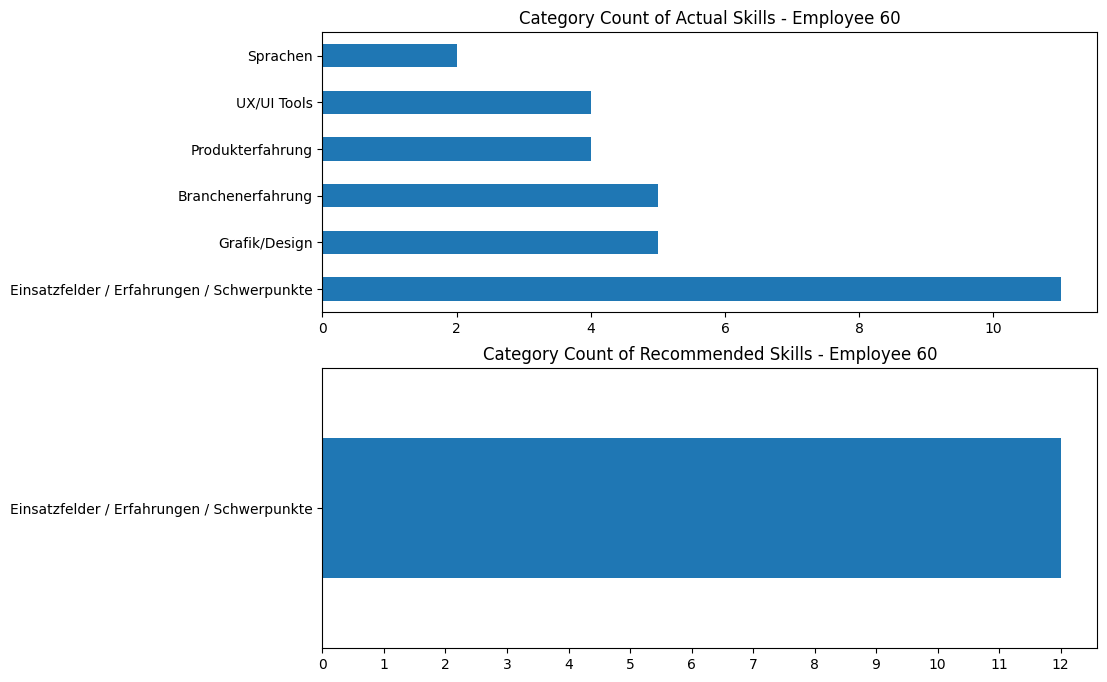

In [512]:
evaluate_employee_recoms(60,12)

Baseline Recommendations: 

In [513]:
baseline = BaselineOnly(verbose=False)
baseline.fit(trainset)
baseline_preds = baseline.test(trainset.build_anti_testset())

In [514]:
baseline_recommendations = get_recommendations(baseline_preds,10)
baseline_recommendations

,0,1,2,3,4,5,6,7,8,9
12,JSF,Jakarta Commons,TestNG,EJB 3,Struts 2,Vue.js,Xerces,Castor,RxJS,Angular (2 und höher)
13,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
15,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
16,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Xerces
17,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
...,...,...,...,...,...,...,...,...,...,...
1467,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
1474,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
1475,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js
1479,JSF,Jakarta Commons,Hibernate,TestNG,EJB 3,JDBC,Struts 2,Spring,Log4J,Vue.js


In [515]:
precision_at_k(10,holdout,baseline_recommendations) 

0.14273775412743894

In [516]:
weighted_precision_at_k(10,holdout,baseline_recommendations) 

0.08193403966701825

Baseline - most often occuring skills 

In [517]:
most_common_skills = list(df["skill"].value_counts().nlargest(10).index)

recom_list = []
for person in range(0,len(persons)):
    recom_list.append(most_common_skills)

baseline_2_recoms = pd.DataFrame(index=persons,columns=np.arange(0,10),data=recom_list)
baseline_2_recoms

,0,1,2,3,4,5,6,7,8,9
12,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
13,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
15,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
16,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
17,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
...,...,...,...,...,...,...,...,...,...,...
1467,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1474,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1475,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1479,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL


In [518]:
precision_at_k(10,holdout,baseline_2_recoms)

0.060032064401691905

In [519]:
weighted_precision_at_k(10,holdout,baseline_2_recoms)

0.012739677612528616

Recommendations for new employee:

In [520]:
def get_recoms_for_new_employee(new_id,skilldict,model):

    all_ids = df_rated["person"].unique()
    all_skills = df_rated["skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in skilldict.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_test = []
    for skill in all_skills:
        try:
            skill_rating = skilldict[skill]
            new_test.append((new_id,skill,skill_rating))
        except KeyError:
            new_test.append((new_id,skill,np.nan))
    
    predictions = model.test(new_test)

    return get_top_n(predictions, n=10)[new_id]

In [521]:
new_id = 8774
new_skills = {
                # "Windows 11":4,
                # "Englisch":4,
                # "Chinesisch (Mandarin)":2,
                "Python":4,
                "MATLAB":2,
                "Java":2,
                "MySQL":3,
                "SQLBase":3,
                "Microsoft SQL Server":3,
                "Google Cloud Platform":2,
                "MongoDB":1,
                "JSON":1,
                "Docker":2,
                "Power BI":3,
                "Postman":2,
                "PowerShell":2,
                "Github actions":2
            }

In [522]:
def get_recoms_for_new_employee_retrain(new_id,new_skills,n):
    all_ids = df_rated["person"].unique()
    all_skills = df_rated["skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in new_skills.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_employee_df = pd.DataFrame()
    new_employee_df["skill"] = new_skills.keys()
    new_employee_df["rating"] = new_skills.values()
    new_employee_df["person"] = new_id
    new_employee_df = new_employee_df[["person","skill","rating"]]

    df_rated_new = pd.concat([df_rated,new_employee_df],ignore_index=True)
    # COMMENT: right now this function creates a new rated df. In order for this to retain newly added employees, it needs to overwrite the old df with the new data. 
    # this had to be implemented later on

    new_data = Dataset.load_from_df(df_rated_new,reader)

    model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
    #  COMMENT: right now the best model from the initial gridearch is taken. if the model is indeed to be retrained, it should be executing a new gridsearch and take the best estimator from this one
    trainset = new_data.build_full_trainset()
    model.fit(trainset)

    testset = trainset.build_anti_testset()
    predictions = model.test(testset)

    return get_top_n(predictions, n)[new_id]

In [523]:
get_recoms_for_new_employee_retrain(new_id,new_skills,20)

[('Jogl', 3.927610868112854),
 ('StyleReport', 3.865403398857459),
 ('Spring-Batch', 3.848460836504676),
 ('Swing/AWT', 3.6596594703270444),
 ('BlackBerry OS', 3.628444285400502),
 ('JSP', 3.6178320190154594),
 ('Kotlin', 3.6130685875993325),
 ('Jakarta Commons', 3.563808641656002),
 ('Xerces', 3.5453036894799284),
 ('Plexus', 3.451917076714532),
 ('Google Web Toolkit', 3.451513181480583),
 ('JDBC', 3.4480114249266496),
 ('EJB 3', 3.4448466428916533),
 ('Log4J', 3.405942719775046),
 ('JSF', 3.3820802157330863),
 ('Swing', 3.38047679533575),
 ('SAP Commerce 6.x', 3.3775698871180326),
 ('Markdown ', 3.3758860001269655),
 ('Velocity', 3.3671333126030394),
 ('JUnit', 3.3547036253883773)]

## Appendix I - Effect of Dropping Rare Skills on Recommender Precision (Sparsity Reduction)

In [524]:
min_absolute_support = [0, 1, 2, 5, 10, 20]

rmse, mse und mae sind bei n = 0,1,2 nan? ??? ?? ?? ??? how 

In [525]:
result_df = pd.DataFrame()#columns = ["n","sparsity","precision_at_k","weighted_precision_at_k","SVD - n_factors"])
for n in min_absolute_support:
    # get data 
    df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")
    # trim dataset according to min absolute support of skills and insert ratings afterwards
    rare_skills = get_rare_skills(df,n)
    df_rated = get_rated_df(df[~df["skill"].isin(rare_skills)])
    # get holdout for later precision measurement 
    holdout = get_holdout(df_rated,0.1)
    # transform data to surprise dataset
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df_rated,reader)
    # measure sparsity (ratio between non-zero and zero value entries)
    sparsity = len(df_rated)/(df_rated["person"].nunique()*df_rated["skill"].nunique())
    algo = (SVD,"SVD",{
                        "n_factors": [1, 2, 5, 10, 20, 40],
                        #"n_factors": [20],
                        #"n_epochs": [500],
                        "n_epochs": [50, 100, 200],
                        #"biased":[False],
                        "biased":[True,False],
                        "random_state":[1]
                                        })
    best_model_dict = {}
    best_params_dict = {}
    rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    # define model, fit and test it on the data
    model = best_model_dict["SVD"]
    trainset = data.build_full_trainset()
    model.fit(trainset)
    preds = model.test(trainset.build_anti_testset())
    print(rmse)
    # save performance measures in df
    new_entry = pd.DataFrame({
                "n":n,
                "unique_skills":df_rated["skill"].nunique(),
                "sparsity":sparsity,
                "precision_at_k":precision_at_k(10,holdout,get_recommendations(preds,10)),
                "weighted_precision_at_k":weighted_precision_at_k(10,holdout,get_recommendations(preds,10)),
                "SVD - n_factors":best_params_dict["SVD"]["n_factors"],
                "SVD - mean rmse": np.mean(rmse),
                "SVD - mean mse": np.mean(mse),
                "SVD - mean mae": np.mean(mae)
                },index=[0])
    result_df = pd.concat([result_df,new_entry],ignore_index=True)
result_df

Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 36.20171356201172
Running CV for model SVD in Iteration: 2 at 71.88472199440002
Total time:  107.6806173324585 sec.
[0.56603248 0.56505576 0.5608898 ]
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 36.28574728965759
Running CV for model SVD in Iteration: 2 at 72.66853380203247
Total time:  109.30836486816406 sec.
[0.54731825 0.55587312 0.5535788 ]
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 36.45232105255127
Running CV for model SVD in Iteration: 2 at 72.8338234424591
Total time:  108.93416738510132 sec.
[0.5378901  0.53717821 0.53659841]
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 36.087289333343506
Running CV for model SVD in Iteration: 2 at 72.07714200019836
Total time:  107.45893263816833 sec.
[0.51180182 0.5036333  0.51955664]
Running CV for model SVD 

,n,unique_skills,sparsity,precision_at_k,weighted_precision_at_k,SVD - n_factors,SVD - mean rmse,SVD - mean mse,SVD - mean mae
0,0,735,0.074517,0.361901,0.190219,20,0.563993,0.318259,0.347342
1,1,666,0.082206,0.325092,0.157133,20,0.552257,0.305218,0.340794
2,2,615,0.088861,0.364285,0.183160,20,0.537222,0.288718,0.334185
3,5,511,0.105193,0.408774,0.226889,20,0.511664,0.262033,0.320046
4,10,393,0.131713,0.423984,0.222375,20,0.499976,0.250118,0.307673
5,20,270,0.178086,0.581825,0.327574,20,0.479258,0.229876,0.289835


## Appendix II - Reverse Problem for User Recommendations on Items

In [526]:
df_items = df_rated[["skill","person","rating"]].sort_values(by="skill")
reader = Reader(rating_scale=(1,5)) 
data_items = Dataset.load_from_df(df_items,reader)
model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
trainset = data_items.build_full_trainset()
model.fit(trainset)

In [527]:
preds = model.test(trainset.build_anti_testset())

In [528]:
get_top_n(preds,10)["Python"]

[(1467, 4.864081714550778),
 (557, 4.8376254268004555),
 (1176, 4.826055747576279),
 (319, 4.819753842651815),
 (172, 4.773519718893669),
 (942, 4.747092928465232),
 (1290, 4.715950846172606),
 (147, 4.694484041464714),
 (855, 4.671964733867797),
 (464, 4.663455855885267)]

In [529]:
df[df["person"] == 711]["category"].value_counts()

Betriebssystem                               17
Dienste                                      14
Programmiersprachen / Scriptsprachen         10
Produkterfahrung                             10
Java Frameworks                               7
Applikationsserver                            7
CI/CD, Build- und Versionskontrollsysteme     6
Datenbank                                     5
Technik/Tools                                 5
Webentwicklung                                5
Umgebungen                                    2
Standards                                     2
Grafik/Design                                 2
.NET Frameworks und Tools                     1
TYPO3                                         1
Entwicklung                                   1
Sprachen                                      1
Name: category, dtype: int64